In [2]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
# from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

def get_Rij(fname):
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats])
    R11 = dat[:,0]
    R12 = dat[:,1]
    R13 = dat[:,2]
    R22 = dat[:,3]
    R23 = dat[:,4]
    R33 = dat[:,5]
    return R11,R12,R13,R22,R23,R33

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"/xz_*")
flist.sort()
print([f.split('/')[-1] for f in flist])

tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 0.4
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['xz_pstrain_0031.h5', 'xz_pstrain_0032.h5', 'xz_pstrain_0071.h5', 'xz_pstrain_0072.h5', 'xz_pstrain_0073.h5']


0.4:[0.000428422490609,6.86572564238e-05],


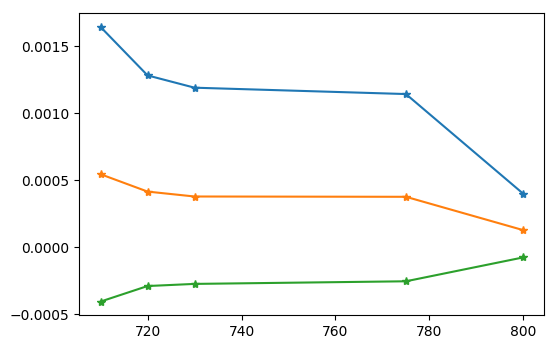

In [47]:

def get_rbar(Mc):
    if Mc == 2: return 0.7
    elif Mc==1.6: return 0.8
    elif Mc==1.2: return 0.85
    elif Mc==0.8: return 0.95
    elif Mc==0.4: return 0.98
    elif Mc==0.2: return 0.995
    
def get_stats(directory,inp,flist_plot):
    mat = np.zeros([len(flist_plot),4])
    for i,fname in enumerate(flist_plot):
        tID = fname.split('/')[-1]
        tID = tID.split('_')[-1]
        tID = int(tID.split('.')[0])
        time = nml.read_time(directory,tID)

        # Get dtheta
        dtheta = get_dtheta(directory,time)

        # Get lscale y
        autocorr = np.fromfile(directory+'shearlayer_lscale_vv_%04d'%(tID)+'.dat',dtype=float,sep=' ')
        ly = get_lscale(y,autocorr)
        
        # Get prms
        hf = h5py.File(directory+'xz_pstrain_%04d'%(tID)+'.h5', 'r')
        dat1 = np.array(hf['p'])
        p = np.var(dat1.flatten())
        prms = np.sqrt(np.mean((dat1.flatten())**2)) #rms

        # Reyolds stresses
        ic = Ny/2
        R11,R12,R13,R22,R23,R33 = get_Rij(directory+'shearlayer_Rij_%04d'%(tID)+'.dat')

        scale = (dtheta/ly)**2 / inp.du**2 
        mat[i,0] = time
        mat[i,1] = prms * scale / get_rbar(inp.Mc)
        mat[i,2] = R22[ic] * scale
        mat[i,3] = R12[ic] * scale
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]

mat = get_stats(directory,inp,flist)
fig = plt.figure(dpi=100)
plt.plot(mat[:,0],mat[:,1],'-*')
plt.plot(mat[:,0],mat[:,2],'-*')
plt.plot(mat[:,0],mat[:,3],'-*')

data = mat[0:-1,2]
print('{}:[{},{}],'.format(inp.Mc,np.mean(data),np.std(data)))

0.2:[-0.000507378012863,5.94505001025e-05],
0.4:[-0.000260599452015,0.000118318447186],
0.8:[-0.000973493733542,0.000156882959371],
1.2:[-0.00106812962958,0.000111886542718],
1.6:[-0.00129438730179,0.000451004091191],
2.0:[-0.00069477823109,0.000165985479154],


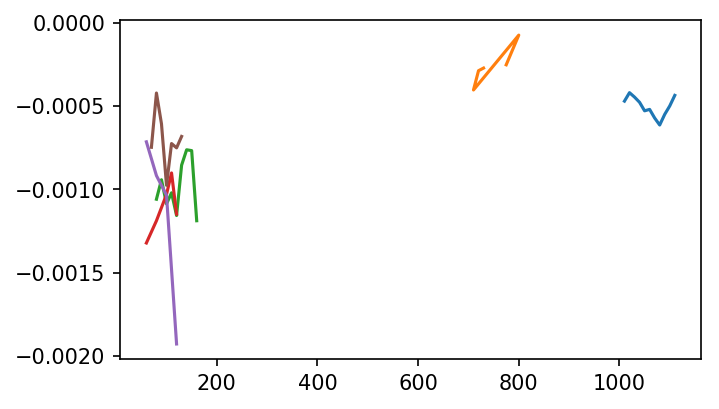

In [7]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    flist = glob.glob(directory+"xz_*")
    flist.sort()

    mat = get_stats(directory,inp,flist)
    t = mat[:,0]
    f = mat[:,3]
    plt.plot(t,f)
    idx = 1
    print('{}:[{},{}],'.format(inp.Mc,np.mean(f[idx:]),np.std(f[idx:])))


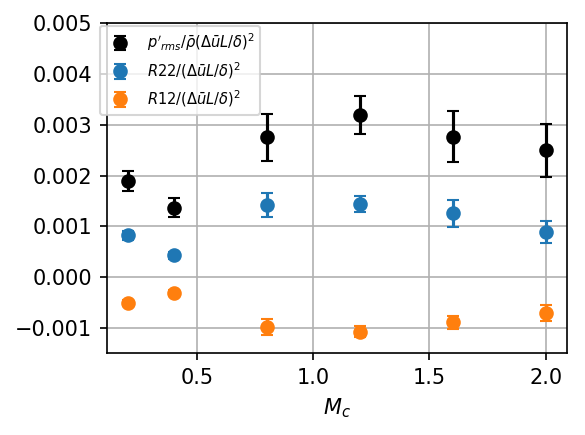

In [25]:
prms = {
    0.2:[0.00189911423417,0.000193836658631],
0.4:[0.00137068859184,0.000195286438742],
0.8:[0.00275416616617,0.000462782960201],
1.2:[0.00318773499308,0.000367010437348],
1.6:[0.00276259973332,0.000496809584245],
2.0:[0.00249396368834,0.000528828975568],
# 0.2:[0.0100013148749,0.000293116287345],
# 0.4:[0.0192015675401,0.00177268241454],
# 0.8:[0.01686202384,0.0020376759445],
# 1.2:[0.0180077165003,0.00145793749352],
# 1.6:[0.0183956130911,0.00163875844635],
# 2.0:[0.0172536801564,0.00149363779131],
}
R22 = {
0.2:[0.00082262546518,8.84305935202e-05],
0.4:[0.000428422490609,6.86572564238e-05],
0.8:[0.00141927266225,0.000234492039444],
1.2:[0.00143878664194,0.000162799253176],
1.6:[0.00125638393534,0.000260664886141],
2.0:[0.00089104052852,0.000211590855995]
# 0.2:[0.00432981254419,0.000139542865317],
# 0.4:[0.00621217955764,0.000618269890465],
# 0.8:[0.00866976440165,0.000860053613341],
# 1.2:[0.00815094383202,0.000899332296267],
# 1.6:[0.00832625375551,0.000473703758262],
# 2.0:[0.00654980299903,0.000460221077835],
}
R12 = {
0.2:[-0.000507378012863,5.94505001025e-05],
0.4:[-0.000305144060964,5.88293244468e-05],
0.8:[-0.000973493733542,0.000156882959371],
1.2:[-0.00106812962958,0.000111886542718],
1.6:[-0.000890110500886,0.000132279391229],
2.0:[-0.000702457793299,0.000154819735785],
# 0.2:[-0.0026700453209,0.000136227150698],
# 0.4:[-0.00431317828818,0.000744641367315],
# 0.8:[-0.00595674206084,0.000644858640309],
# 1.2:[-0.00604531431646,0.000540791407904],
# 1.6:[-0.00613050066112,0.000925893951946],
# 2.0:[-0.00514064185638,0.000851335441758],
}

def plotter(dat,label,fmt):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],fmt=fmt,label=label,capsize=3)

fig = plt.figure(figsize=(4,3),dpi=150)
plotter(prms,r"$p'_{rms}/\bar{\rho}(\Delta \bar{u}L/\delta)^2$",'ko')
plotter(R22,r'$R22/(\Delta \bar{u}L/\delta)^2$','o')
plotter(R12,r'$R12/(\Delta \bar{u}L/\delta)^2$','o')

plt.grid(True)
plt.xlabel(r'$M_c$')
plt.legend(fontsize=7,bbox_to_anchor=(0.35,.7))
plt.ylim([-0.0015,0.005])
# plt.xlim([0,2.1])
plt.tight_layout()
# plt.savefig('/home/kmatsuno/ShearLayer_img/Rij.png',dpi=200, bbox_inches='tight')